### Santolik_method_plots_for_HGI_proposal
    This is the notebook I used to generate the gridded figures of RBSP data, for the original HGI proposal.
    It shows how to parse the RBSP files (IDL .sav files), and how to apply the methods in santolik_methods.py
    
    This notebook should run top to bottom as-is!
    - Austin, 4.13.2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import datetime
import scipy.signal
import scipy.linalg
import matplotlib.gridspec as gridspec
from scipy import interpolate
from scipy import ndimage

from santolik_methods import fill_nans, santolik_Q
from scipy.signal.windows import hann, blackman, nuttall

%matplotlib inline
D2R = np.pi/180.
R2D = 180./np.pi
Hz2Rad = 2.*np.pi
Rad2Hz = 1./Hz2Rad

Q_EL = 1.602e-19
M_EL = 9.1e-31
eo   = 8.854e-12
B0   = 30e-6
VC    = 2.998e8
mu = 4.*np.pi*10e-7

# Reduce precision when printing stuff out...
np.set_printoptions(precision=3,suppress=False)

%load_ext autoreload
%autoreload 2



In [2]:
datadir = 'RBSP_example_data_data/'
d = os.listdir(datadir)
files = sorted([x for x in d if x.endswith('.sav')])

# for fn, file in enumerate(files):
file = files[18]

data = scipy.io.readsav(os.path.join(datadir,file))
print(data.keys())
tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
# print(data.keys())
ex   = data['local_e12']
ey   = data['local_e34']
ez   = data['local_e56']
bx   = data['local_scmx']
by   = data['local_scmy']
bz   = data['local_scmz']


tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
# print(np.array(tvec))
# fs = 1.0/np.diff(data['local_et']).mean()
fs = 16000


dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])


9.483678971436069e-11 2.5082951400993484e-05
7.693067667582331e-11 5.016708008285288e-06
8.571456276234248e-11 2.278913995556651e-05
1.0843246288732976e-07 0.004238596789085456
1.3055169163161625e-07 0.004430817961367944
4.016257724578844e-09 0.005904056890870466


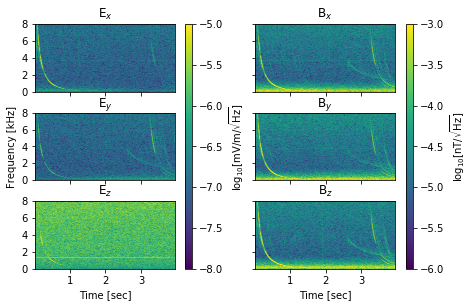

In [3]:
def plot_spec():
    # --------------- Latex Plot Beautification --------------------------
    fig_width = 6 
    fig_height = 3.5
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 10,
              'font.size': 10,
              'legend.fontsize': 8,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------

    # fig, ax = plt.subplots(3,2,sharex=True,sharey=True)
    fig = plt.figure()
    gs = gridspec.GridSpec(3,5, width_ratios=[1,0.05, 0.3, 1, 0.05])
    gs.update(wspace=0.15, hspace=0.3) # set the spacing between axes.
    eax = []
    eax.append(plt.subplot(gs[0,0]))
    eax.append(plt.subplot(gs[1,0]))
    eax.append(plt.subplot(gs[2,0]))

    ecbax = plt.subplot(gs[:,1])

    bax = []
    bax.append(plt.subplot(gs[0,3]))
    bax.append(plt.subplot(gs[1,3]))
    bax.append(plt.subplot(gs[2,3]))

    bcbax = plt.subplot(gs[:,4])
    yticks = [0, 2000, 4000, 6000, 8000]
    yticklabels = [0, 2, 4, 6, 8]
    nfft = 512
    overlap = 0.5
    window = 'hanning'
    cm = plt.cm.viridis
    c = 2.998e8
    # Get spectra
    ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='psd',scaling='density')
    ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='psd',scaling='density')
    ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='psd',scaling='density')

    ff,tt, FEx = scipy.signal.spectrogram(1e-3*ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='psd',scaling='density')
    ff,tt, FEy = scipy.signal.spectrogram(1e-3*ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='psd',scaling='density')
    ff,tt, FEz = scipy.signal.spectrogram(1e-3*ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='psd',scaling='density')

    E_clims=[-8,-5]
    B_clims=[-6,-3]

    S_mag = np.sqrt(FEx)
    print(np.min(S_mag), np.max(S_mag))
    p = eax[0].pcolormesh(tt,ff, np.log10(S_mag), cmap = cm, vmin=E_clims[0],vmax=E_clims[1],shading='gouraud')
    S_mag = np.sqrt(FEy)
    print(np.min(S_mag), np.max(S_mag))
    p = eax[1].pcolormesh(tt,ff, np.log10(S_mag), cmap = cm, vmin=E_clims[0],vmax=E_clims[1],shading='gouraud')
    # S_mag = np.real(newEz*np.conj(newEz))
    S_mag = np.sqrt(FEz)
    print(np.min(S_mag), np.max(S_mag))
    p = eax[2].pcolormesh(tt,ff, np.log10(S_mag), cmap = cm, vmin=E_clims[0],vmax=E_clims[1],shading='gouraud')

    ec = plt.colorbar(p, cax = ecbax)

    S_mag = np.sqrt(FBx)
    print(np.min(S_mag), np.max(S_mag))
    p = bax[0].pcolormesh(tt,ff, np.log10(S_mag), cmap = cm,vmin=B_clims[0],vmax=B_clims[1],shading='gouraud')
    S_mag = np.sqrt(FBy)
    print(np.min(S_mag), np.max(S_mag))
    p = bax[1].pcolormesh(tt,ff, np.log10(S_mag), cmap = cm,vmin=B_clims[0],vmax=B_clims[1],shading='gouraud')
    S_mag = np.sqrt(FBz)
    print(np.min(S_mag), np.max(S_mag))
    p = bax[2].pcolormesh(tt,ff, np.log10(S_mag), cmap = cm,vmin=B_clims[0],vmax=B_clims[1],shading='gouraud')

    bc = plt.colorbar(p, cax = bcbax)



    bax[0].set_yticklabels([])
    bax[1].set_yticklabels([])
    bax[2].set_yticklabels([])

    eax[0].set_xticklabels([])
    eax[1].set_xticklabels([])

    bax[0].set_xticklabels([])
    bax[1].set_xticklabels([])

    eax[2].set_xlabel('Time [sec]')
    bax[2].set_xlabel('Time [sec]')

    eax[0].set_title('E$_x$')
    eax[1].set_title('E$_y$')
    eax[2].set_title('E$_z$')
    bax[0].set_title('B$_x$')
    bax[1].set_title('B$_y$')
    bax[2].set_title('B$_z$')

    for i in [0,1,2]:
        eax[i].set_yticks(yticks)
        eax[i].set_yticklabels(yticklabels)
        bax[i].set_yticks(yticks)
        bax[i].set_yticklabels([])

    eax[1].set_ylabel('Frequency [kHz]')

    ec.set_label('log$_{10}$[mV/m/$\sqrt{\mathrm{Hz}}$]')
    bc.set_label('log$_{10}$[nT/$\sqrt{\mathrm{Hz}}$]')
    plt.subplots_adjust(left=0.1, right=0.85)


    return fig
fig = plot_spec();




/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


filling imag
Getting Q matrices


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


f_blurred is (129, 495)
(129,)
[0. 1. 2. 3. 4.]
(495, 129, 6, 6)


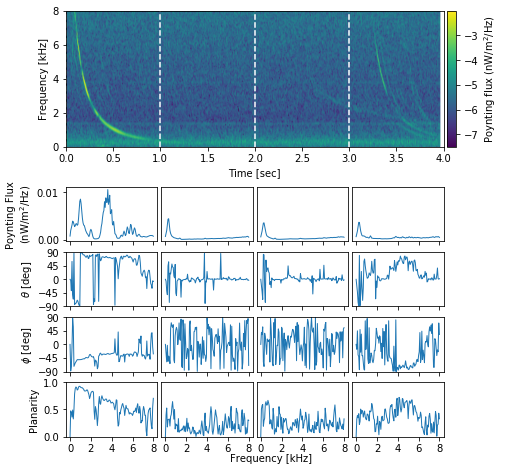

In [4]:
# Everything on one cool divided plot!
def plot_grid():
    subsample_length = 1 # seconds

    # file_index = 16
    # for file_index in [18]:
    #     file = files[file_index]

    # data = scipy.io.readsav(os.path.join(datadir,file))
    # print(data.keys())
    tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
    # print(data.keys())
    ex   = data['local_e12']*1e-3
    ey   = data['local_e34']*1e-3
    ez   = data['local_e56']*1e-3
    bx   = data['local_scmx']*1e-9
    by   = data['local_scmy']*1e-9
    bz   = data['local_scmz']*1e-9


    tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]

    # fs = 1.0/np.diff(data['local_et']).mean()
    fs = 16000
    overlap = 0.5
    nfft = 256
    window = nuttall(nfft)

    ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

    ff,tt, FEx = scipy.signal.spectrogram(ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FEy = scipy.signal.spectrogram(ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FEz = scipy.signal.spectrogram(ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

    # Recreate Ez, because RBSP's measurement is noisy anyway
    ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/np.real(FBz)
    ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/np.imag(FBz)

    if np.sum(np.isnan(ReEz))>0:
        print('filling real')
        fill_nans(tt,ff,ReEz)
    if np.sum(np.isnan(ImEz))>0:
        print('filling imag')
        fill_nans(tt,ff,ImEz)

    newEz = ReEz + 1j*ImEz

    # Get poynting flux
    flux = np.zeros([len(ff), len(tt)])

    FB = np.array([FBx, FBy, FBz])
    FE = np.array([FEx, FEy, FEz])
    for ti in range(len(tt)):
        for fi in range(len(ff)):  
            poy = np.cross(FE[:,fi,ti], FB[:,fi,ti])
            flux[fi,ti] = np.real(np.linalg.norm(poy))
    flux = np.real(flux)/mu


    # Generate Q matrix, so we can play with it
    print("Getting Q matrices")
    Qvec = np.zeros([len(tt), len(ff),6,6])
    for ti in range(len(tt)):
        t = tt[ti]
        for fi in np.arange(1,len(ff)):
            z = np.array([VC*FBx[fi,ti], VC*FBy[fi,ti], VC*FBz[fi,ti], FEx[fi,ti], FEy[fi,ti], FEz[fi,ti]],'complex')
            Q = np.outer(z,np.conj(z))

            Qvec[ti,fi] = Q


    thresh_multiplier = 3
    # Get threshold magnitude:
    # (Sum of the auto power spectra)
    # F_mags = np.absolute(VC*(FBx*np.conj(FBx) + FBy*np.conj(FBy) + FBz*np.conj(FBz)) 
    #                       + (FEx*np.conj(FEx) + FEy*np.conj(FEy) + FEz*np.conj(FEz)))

    # Get average
    F_blurred = ndimage.uniform_filter(flux, size=3)
    print('f_blurred is', np.shape(F_blurred))
    F_avg  = np.sum(F_blurred,axis=-1)/(np.shape(F_blurred)[0])
    thresh = np.where(F_blurred - F_avg[:,np.newaxis]*thresh_multiplier > 0)
    # sparse = FD_full_to_sparse([FEx, FEy, FBx, FBy, FBz], thresh)

    Fxs = np.zeros_like(FEx, 'complex')
    Fxs[thresh] = FEx[thresh]

    # fig, ax = plt.subplots(1,1)
    # ax.pcolormesh(tt,ff,np.log10(np.abs(Fxs)))
    print(np.shape(F_avg))
    theta_vec = np.zeros([len(ff), len(tt)])
    phi_vec   = np.zeros([len(ff), len(tt)])
    plan_vec  = np.zeros([len(ff), len(tt)])

    for fi,ti in zip(thresh[0], thresh[1]):
        theta, phi, planarity = santolik_Q(Qvec[ti,fi,:,:])
        theta_vec[fi,ti] = theta
        phi_vec[fi,ti] = phi
        plan_vec[fi,ti] = planarity


    # Find peak index for each frequency:
    tmax_inds = np.argmax(F_blurred, axis=1)

    theta_pk = np.zeros(len(ff))
    phi_pk   = np.zeros(len(ff))
    plan_pk  = np.zeros(len(ff))

    for fi in range(len(ff)):
        theta_pk[fi], phi_pk[fi], plan_pk[fi] = santolik_Q(Qvec[tmax_inds[fi], fi, :, :])

    #     flux_pk = np.array([flux[fi, tmax_inds[fi]] for fi in range(len(ff))])
    # use the blurred flux, because it's smoother and prettier
    flux_pk = np.array([F_blurred[fi, tmax_inds[fi]] for fi in range(len(ff))])

    # Previous cell break here    

    # Find peak index for each frequency:
    tmax_inds = np.argmax(F_blurred, axis=1)


    # --------------- Latex Plot Beautification --------------------------
    fig_width = 6
    fig_height = 6
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 10,
              'font.size': 10,
              'legend.fontsize': 8,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------
    import matplotlib.gridspec as gridspec



    t_sub = np.arange(0,tt[-1] + subsample_length,subsample_length)
    print(t_sub)

    t_pairs = list(zip(t_sub[0:-1], t_sub[1:]))


    fig = plt.figure();

    widths = np.ones(len(t_pairs) + 1)
    widths[-1] = 0.1
    gs1 = gridspec.GridSpec(1, len(t_pairs) +1, width_ratios = widths)
    ax1 = plt.subplot(gs1[0, 0:-1])
    cax = plt.subplot(gs1[0, -1])

    im1 = ax1.pcolormesh(tt,ff,np.log10(flux*1e9), cmap = plt.cm.viridis, shading='gouraud')
    #     p = eax[0].pcolormesh(tt,ff, np.log10(S_mag), cmap = cm, vmin=E_clims[0],vmax=E_clims[1],shading='gouraud')



    cb = fig.colorbar(im1, cax=cax, orientation='vertical')
    cb.set_label('Poynting flux (nW/m$^2$/Hz)')
    ax1.set_xlim([0,4])
    ax1.set_ylim([0, 8000])

    ax1.set_ylabel('Frequency [kHz]')
    ax1.set_xlabel('Time [sec]')

    freq_ticks = [0, 2000, 4000, 6000, 8000]
    freq_labels = [0,2,4,6,8]

    angle_ticks = np.arange(-180, 181, 45)

    ax1.set_yticks(freq_ticks)
    ax1.set_yticklabels(freq_labels)

    for t in t_sub:
        ax1.plot([t,t],[0,8000],'w--')
    print(np.shape(Qvec))

    flux_list = []
    theta_list =[]
    phi_list = []
    plan_list = []

    gs2 = gridspec.GridSpec(4, len(t_pairs) +1, width_ratios = widths)
    gs1.update(top=0.92, bottom=0.65, wspace=0.05)
    gs2.update(top=0.57, bottom=0.075, wspace=0.05)


    for ind, (t1, t2) in enumerate(t_pairs):
        ax = plt.subplot(gs2[0, ind])
        flux_list.append(ax)

        ax = plt.subplot(gs2[1, ind])
        theta_list.append(ax)

        ax = plt.subplot(gs2[2, ind])
        phi_list.append(ax)

        ax = plt.subplot(gs2[3, ind])
        plan_list.append(ax)


    linewidth = 1
    for ind, (t1, t2) in enumerate(t_pairs):
        Q_avg = np.sum(Qvec[(tt >= t1) & (tt < t2),:,:,:], axis=0)/len(tt)
        theta_avg = np.zeros(len(ff))
        phi_avg   = np.zeros(len(ff))
        plan_avg  = np.zeros(len(ff))
        flux_sum  = np.sum(flux[:,(tt >= t1) & (tt < t2)],axis=-1)


        for i in range(len(ff)):
            theta_avg[i], phi_avg[i], plan_avg[i] = santolik_Q(Q_avg[i])

        # Plot poynting flux
        ax = flux_list[ind]
        ax.plot(ff, flux_sum*1e9, linewidth=linewidth)

        # Plot theta
        ax = theta_list[ind]
        ax.plot(ff, theta_avg*R2D, linewidth=linewidth)
        ax.set_ylim([-90,90])

        # Plot phi
        ax = phi_list[ind]
        ax.plot(ff, phi_avg*R2D, linewidth=linewidth)
        ax.set_ylim([-90,90])

        # Plot planarity
        ax = plan_list[ind]
        ax.plot(ff, plan_avg, linewidth=linewidth)
        ax.set_ylim([0,1])

    # Clean up ticks and labels    
    for ax in phi_list:
        ax.set_yticks(angle_ticks)
        ax.set_ylim([-90,90])
    for ax in theta_list:
        ax.set_yticks(angle_ticks)
        ax.set_ylim([-90,90])

    for ax in flux_list[1:]:
        ax.set_ylim(flux_list[0].get_ylim())
        ax.set_yticks([])
    for ax in theta_list[1:]:
        ax.set_yticks([])
    for ax in phi_list[1:]:
        ax.set_yticks([])
    for ax in plan_list[1:]:
        ax.set_yticks([])
    for ax in flux_list:
        ax.set_xticks(freq_ticks)
        ax.set_xticklabels([])
    for ax in theta_list:
        ax.set_xticks(freq_ticks)
        ax.set_xticklabels([])
    for ax in phi_list:
        ax.set_xticks(freq_ticks)
        ax.set_xticklabels([])
    for ax in plan_list:
        ax.set_xticks(freq_ticks)
        ax.set_xticklabels(freq_labels)


    fig.text(0.45, 0.025, "Frequency [kHz]")

    flux_list[0].set_ylabel('Poynting Flux\n(nW/m$^2$/Hz)');
    theta_list[0].set_ylabel(r'$\theta$ [deg]');
    phi_list[0].set_ylabel(r'$\phi$ [deg]');
    plan_list[0].set_ylabel('Planarity')

    return fig

fig = plot_grid();
# fig.suptitle('RBSP wave data, %s'%tvec[0].strftime('%d/%m/%Y, %H:%M UTC'))
# fig.savefig('figures for HGI proposal/grid_plot_%s.pdf'%file.split('.')[0])


#     plt.close('all')

dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


filling imag
Getting Q matrices


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


f_blurred is (129, 495)
(129,)
[0. 1. 2. 3. 4.]
(495, 129, 6, 6)
dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag
Getting Q matrices
f_blurred is (129, 495)
(129,)
[0. 1. 2. 3. 4.]
(495, 129, 6, 6)
dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag
Getting Q matrices
f_blurred is (129, 495)
(129,)
[0. 1. 2. 3. 4.]
(495, 129, 6, 6)
dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag
Getting Q matrices
f_blurred is (129, 495)
(129,)
[0. 1. 2. 3. 4.]
(495, 129, 6, 6)
dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag
Getting Q matrices
f_blurred is (129, 495)
(129,)
[0. 1. 2. 3. 4.]
(495, 129, 6, 6)
dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_sc

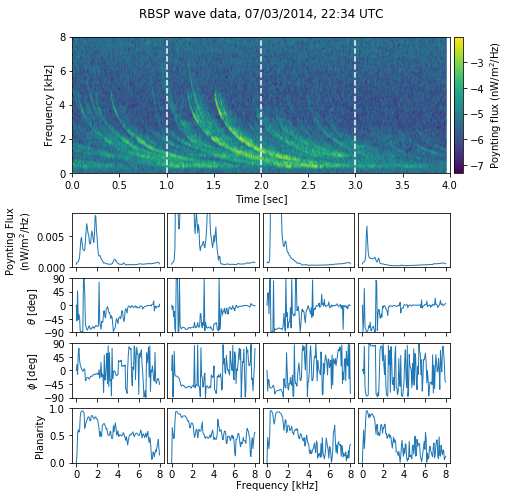

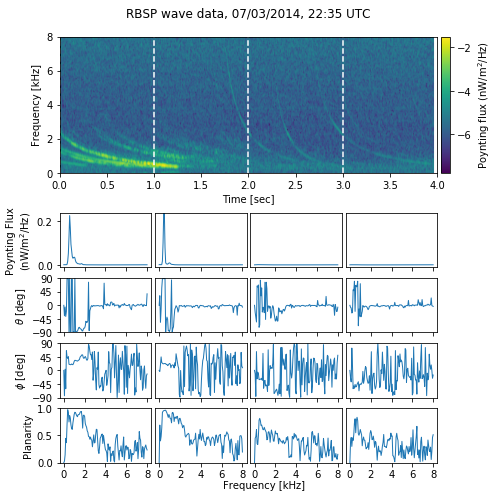

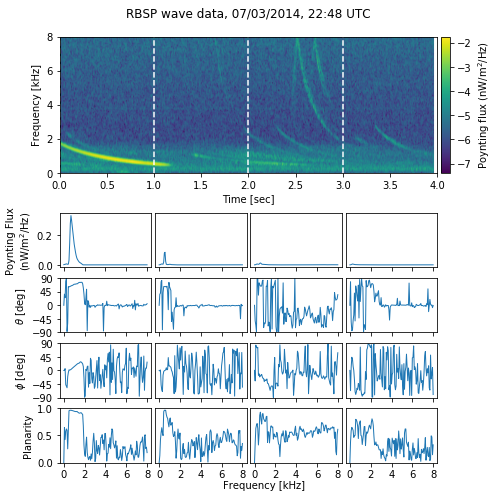

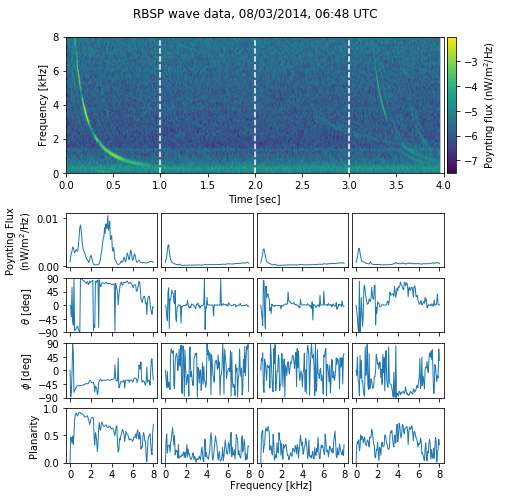

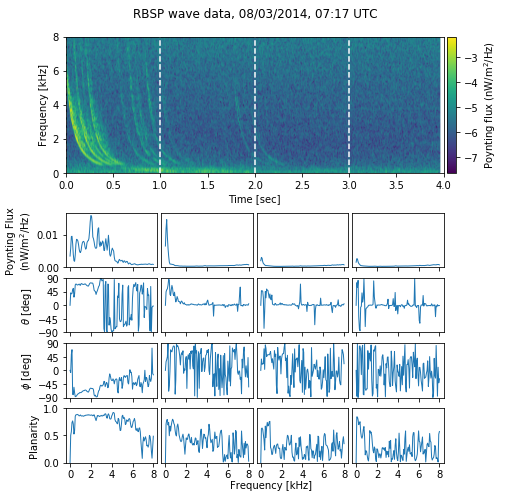

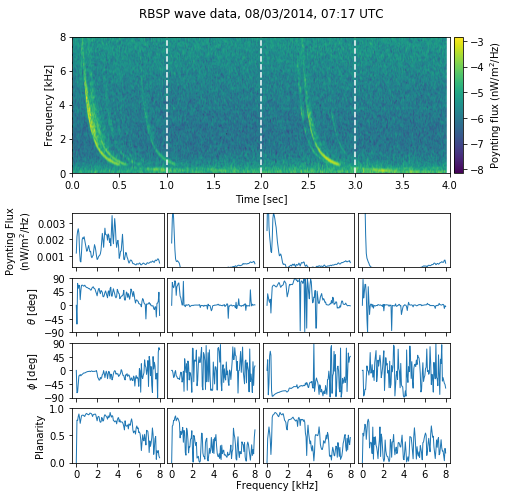

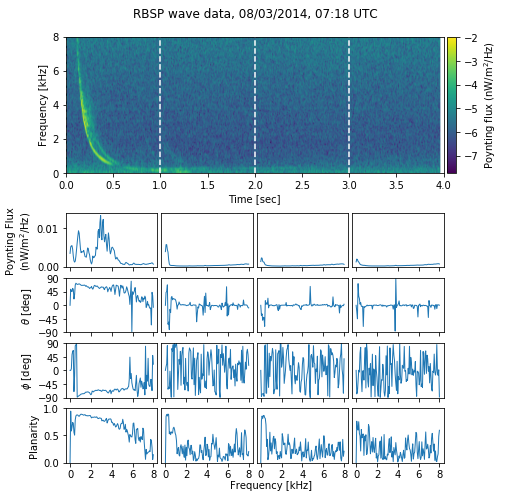

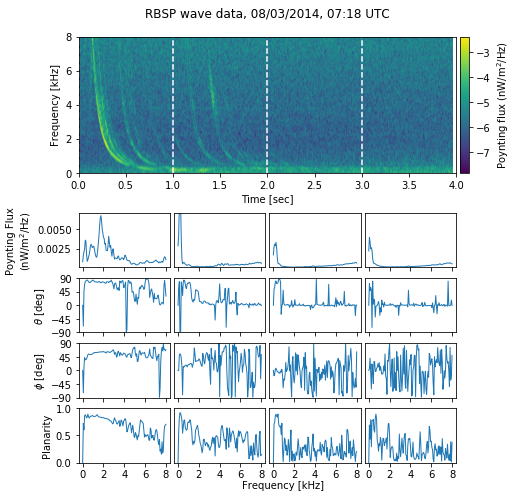

In [5]:
# Generate a grid plot for each file in the RBSP data directory:

datadir = 'RBSP_example_data_data/'
d = os.listdir(datadir)
files = sorted([x for x in d if x.endswith('.sav')])
files_to_do = [1, 3, 16, 18, 20, 21, 22, 23]
for ind in files_to_do:
    file = files[ind]

    data = scipy.io.readsav(os.path.join(datadir,file))
    print(data.keys())
    tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
    # print(data.keys())
    ex   = data['local_e12']
    ey   = data['local_e34']
    ez   = data['local_e56']
    bx   = data['local_scmx']
    by   = data['local_scmy']
    bz   = data['local_scmz']


    tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
    # print(np.array(tvec))
    # fs = 1.0/np.diff(data['local_et']).mean()
    fs = 16000
    

#     fig = plot_spec()
#     fig.suptitle('RBSP wave data, %s'%tvec[0].strftime('%d/%m/%Y, %H:%M UTC'))
#     fig.savefig('figures for HGI proposal/fd_plot_%s.pdf'%file.split('.')[0])

    fig = plot_grid()
    fig.suptitle('RBSP wave data, %s'%tvec[0].strftime('%d/%m/%Y, %H:%M UTC'))
    fig.savefig('figures for HGI proposal/grid_plot_%s.pdf'%file.split('.')[0])

